<a href="https://colab.research.google.com/github/manycoding/siamese/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Matching

In [1]:
!pip install -q fastai2

     |████████████████████████████████| 194kB 4.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# 16280MiB P100
# 15079MiB T4
# 11441MiB K80
# 7611MiB P4
gpu_info = !nvidia-smi
gpu = 1
if "Tesla T4" in gpu_info[7]:
    gpu = 0.92
elif "K80" in gpu_info[7]:
    gpu = 0.70
elif "Tesla P4" in gpu_info[7]:
    gpu = 0.46
gpu

1

In [0]:
from pathlib import Path
import gc

In [0]:
from fastai2.data.external import untar_data,URLs
from fastai2.data.transforms import get_image_files

## Data

In [0]:
root_dir = Path("/content/gdrive/My Drive/")
home = root_dir/"upwork/siamese"
home.mkdir(parents=True, exist_ok=True)

In [0]:
# !unzip -q "{home}/updated.zip" -d "{home}/data"

In [0]:
import torch
import numpy as np
import PIL

In [0]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [0]:
files = get_image_files(home/"data/Query")

In [11]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [0]:
import re
def label_func(fname):
    return fname.parent.name

In [13]:
label_func(files[-1])

'green'

In [0]:
import random

Only red and green labels have enough samples, so I excluded others.

In [0]:
labels = ["green", "red"]

In [0]:
lbl2files = {"green": (home/"data/Query/green").ls(),
             "red": (home/"data/Query/red").ls(),
             "no_match": (home/"data/Query/no_match").ls()
             }

In [0]:
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

In [0]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=same_breed, ctx=ctx, **kwargs)

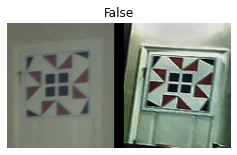

In [19]:
img = PILImage.create(files[6])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();

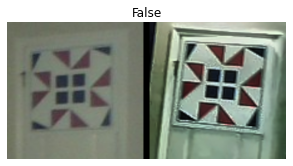

In [20]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

In [0]:
class ImageTuple(Tuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [22]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorImage)

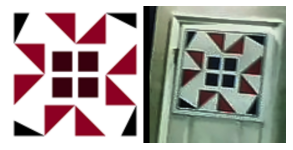

In [23]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [0]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [0]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(lbl2files[cls]),same

In [0]:
def get_tuple_files(path):
    files = get_image_files(path)[1:]
    return [[f, *draw_other(f)] for f in files]

In [0]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [0]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuple_files,
    get_x=get_x, get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

## Model

In [0]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [30]:
encoder = create_body(resnet152, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
head = create_head(512*4*4, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [32]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=8192, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [0]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [0]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [0]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls))
        if cls == "no_match":
            other_cls = random.choice(L(l for l in labels if l != cls and l != label_func(f)))
            return random.choice(lbl2files[other_cls]),False
        return random.choice(lbl2files[cls]),same

In [0]:
BS=16

In [0]:
splits = RandomSplitter(seed=42)(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      bs=BS)

In [0]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], x[2][i].item()).show(ctx=ctx)

In [0]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

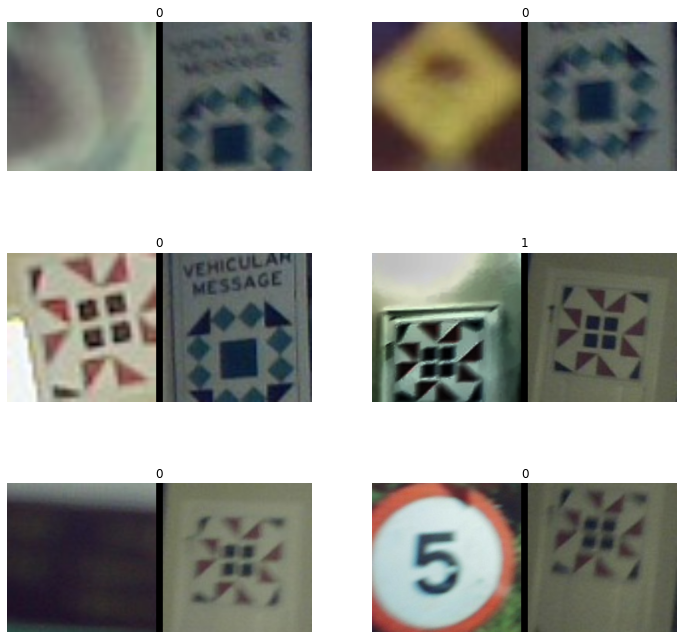

In [40]:
dls.show_batch()

In [0]:
# 1/0

In [0]:
# learn = None
# gc.collect()
# torch.cuda.empty_cache()

In [0]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter,
                metrics=accuracy, path=home)

In [0]:
learn.freeze()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.015848932787775993)

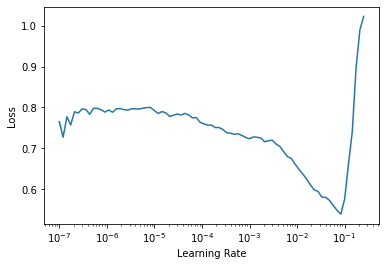

In [49]:
# learn.lr_find()

In [50]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.772280,1.504776,0.285714,00:07
1,0.830483,2.872054,0.321429,00:02
2,0.750986,1.034740,0.678571,00:02
3,0.697047,0.613365,0.750000,00:02


In [0]:
learn.unfreeze()

In [52]:
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.733528,0.500210,0.785714,00:03
1,0.720998,0.442533,0.857143,00:03
2,0.664450,0.213477,0.928571,00:03
3,0.599321,0.225876,1.000000,00:03
4,0.561979,0.235424,0.964286,00:03


In [53]:
learn.fit_one_cycle(5, slice(1e-7,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.425935,0.247903,0.892857,00:03
1,0.439495,0.260992,0.892857,00:03
2,0.424278,0.260836,0.892857,00:03
3,0.417542,0.276806,0.892857,00:03
4,0.416320,0.281104,0.857143,00:03


In [54]:
learn.fit_one_cycle(5, slice(1e-9,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.351373,0.271541,0.892857,00:03
1,0.413622,0.264285,0.857143,00:03
2,0.429092,0.260389,0.964286,00:03
3,0.458316,0.260332,0.892857,00:03
4,0.444825,0.251166,0.964286,00:03


In [0]:
# learn.path = home
learn.save("siamese.pth")

In [0]:
len(learn.dls.valid_ds)

In [0]:
# Results from different architectures
#resnet18 0.82
#resnet34 0.75
#resnet50 0.82
#resnet101 0.85
#resnet152 0.928

In [0]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'{[False,True][x[2][i].item()]}\n{[False,True][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

In [0]:
learn.show_results()

#ONNX

In [44]:
!pip install -q onnx onnxruntime

     |████████████████████████████████| 4.8MB 5.0MB/s 
     |████████████████████████████████| 3.7MB 54.6MB/s 


In [0]:
x1,x2,y = dls.one_batch()

In [0]:
learn = learn.load("siamese.pth")

In [0]:
torch_out = learn.model(x1,x2)

In [0]:
# Export the model
torch.onnx.export(learn.model,               # model being run
                  (x1, x2),  # model input (or a tuple for multiple inputs)
                  "siamese.onnx",            # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['x1', 'x2'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'x1' : {0 : 'batch_size'},    # variable lenght axes
                                'x2' : {0 : 'batch_size'}, 
                                'output' : {0 : 'batch_size'}})

In [0]:
import onnx

onnx_model = onnx.load("siamese.onnx")
onnx.checker.check_model(onnx_model)

In [0]:
# print(onnx.helper.printable_graph(onnx_model.graph))

In [0]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("siamese.onnx")

def to_numpy(t1):
    return t1.detach().cpu().numpy() if t1.requires_grad else t1.cpu().numpy()

In [55]:
ort_session.get_inputs()[1].name

'x2'

In [61]:
# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x1),
              ort_session.get_inputs()[1].name: to_numpy(x2)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

AssertionError: ignored